In [1]:
%pylab inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Objective function analysis
VIC parameters were calibrated with NSE, scaled KGEs and annual peak Q error, at each of 670 HCDN basins independently. SCE was used with 20,000 maximum trials. 

In [2]:
# Getting Data: 
# 1. Parameters traced during SCE [n_hru x n_par x n_iteration]
# 2. hydrologic signatures traced during SCE [n_hru x n_sig x n_iteration]
# 3. final calibrated parameters [n_hru x n_calpar]
# 4. Camel dataset [n_hru x n_attr]

data_path = './data'

main_obj_fun = ['nse','kge','kge_2alpha','kge_5alpha','sig1']
sup_obj_fun = ['kge_alpha'] #'kge_10alpha'

ds_flow_all = xr.open_dataset('%s/results_hcdn_flow.nc'%data_path)

df_hcdn = pd.read_csv('%s/hcdn.calib.conus.list'%data_path, delim_whitespace=True,
                   header=None, names=['id', 'lat', 'lon'])

nbasin = len(df_hcdn['id'])
ndata = len(main_obj_fun)
sup_ndata = len(sup_obj_fun)

print(ds_flow_all)

<xarray.Dataset>
Dimensions:      (hcdn: 670, time: 6940)
Coordinates:
  * hcdn         (hcdn) int64 1013500 1022500 1030500 1031500 1047000 ...
  * time         (time) datetime64[ns] 1989-10-01 1989-10-02 1989-10-03 ...
Data variables:
    nse          (hcdn, time) float64 0.3794 0.4213 0.4643 0.4907 0.5003 ...
    kge          (hcdn, time) float64 0.6081 0.6508 0.6938 0.7171 0.7214 ...
    kge_alpha    (hcdn, time) float64 0.318 0.3453 0.373 0.3895 0.3955 ...
    kge_2alpha   (hcdn, time) float64 0.5664 0.6209 0.6755 0.7058 0.7126 ...
    kge_5alpha   (hcdn, time) float64 0.5486 0.6096 0.6713 0.7068 0.7165 ...
    kge_10alpha  (hcdn, time) float64 0.5498 0.6093 0.6696 0.7044 0.7143 ...
    sig1         (hcdn, time) float64 0.5286 0.5628 0.5982 0.6184 0.6249 ...
    obs          (hcdn, time) float64 0.3248 0.3215 0.3388 0.3204 0.3096 ...


Functions defined

In [3]:
def nse(qsim, qobs):
    return 1-np.sum((qsim-qobs)**2)/np.sum((qobs-np.mean(qobs))**2)

    
def corr(qsim, qobs):
    return np.corrcoef(qsim, qobs)[0, 1]
    
    
def alpha(qsim, qobs):
    return math.sqrt(np.sum((qsim-np.mean(qsim))**2)/len(qsim))/math.sqrt(np.sum((qobs-np.mean(qobs))**2)/len(qobs))
    

def beta(qsim, qobs):
    return np.mean(qsim)/np.mean(qobs)


def kge(qsim, qobs):
    return 1-math.sqrt((1-corr(qsim, qobs))**2 + (alpha(qsim, qobs)-1)**2 + (beta(qsim, qobs)-1)**2)


def pbias(qsim, qobs):
    return np.sum((qsim-qobs))/np.sum(qobs)

In [4]:
#calibration period
ds_flow_cal = ds_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))

#Initialize arrays
nse_cal_array = np.zeros((nbasin, ndata))
alpha_cal_array = np.zeros((nbasin, ndata))
beta_cal_array = np.zeros((nbasin, ndata))
corr_cal_array = np.zeros((nbasin, ndata))
kge_cal_array = np.zeros((nbasin, ndata))
pbiasFHV_cal_array = np.zeros((nbasin, ndata))
pbiasQpeak_cal_array = np.zeros((nbasin, ndata))

prob_cal=np.arange(1,float(len(ds_flow_cal['time'])+1))/(1+len(ds_flow_cal['time'])) #probability
for d in range(len(prob_cal)):
    idx50=d
    if prob_cal[d] > 0.5: break
for d in range(len(prob_cal)):
    idx30=d
    if prob_cal[d] > 0.3: break
for d in range(len(prob_cal)):
    idx80=d
    if prob_cal[d] > 0.8: break
    
r=0
for hid in df_hcdn['id']:
    for c, obj in enumerate(main_obj_fun): 
        sr_sim = ds_flow_cal[obj].sel(hcdn=hid).to_pandas()        
        sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
        sr_sim_sort = sr_sim.sort_values()
        sr_sim_ann=sr_sim.resample('A-SEP').max()
        if c == 0:
            sr_obs = ds_flow_cal['obs'].sel(hcdn=hid).to_pandas()
            sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
            sr_obs_sort = sr_obs.sort_values()
            sr_obs_ann=sr_obs.resample('A-SEP').max()
            
        nse_cal_array[r,c] = nse(sr_sim, sr_obs)
        alpha_cal_array[r,c] = alpha(sr_sim, sr_obs)
        beta_cal_array[r,c] = beta(sr_sim, sr_obs)
        corr_cal_array[r,c] = corr(sr_sim, sr_obs)
        kge_cal_array[r,c] = kge(sr_sim, sr_obs)
        pbiasQpeak_cal_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
        pbiasFHV_cal_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
    r += 1


In [5]:
# Validation period
ds_flow_val = ds_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))

#Initialize arrays
nse_val_array = np.zeros((nbasin, ndata))
alpha_val_array = np.zeros((nbasin, ndata))
beta_val_array = np.zeros((nbasin, ndata))
corr_val_array = np.zeros((nbasin, ndata))
kge_val_array = np.zeros((nbasin, ndata))
pbiasFHV_val_array = np.zeros((nbasin, ndata))
pbiasQpeak_val_array = np.zeros((nbasin, ndata))

prob_val=np.arange(1,float(len(ds_flow_val['time'])+1))/(1+len(ds_flow_val['time'])) #probability
for d in range(len(prob_val)):
    idx50=d
    if prob_val[d] > 0.5: break
for d in range(len(prob_val)):
    idx30=d
    if prob_val[d] > 0.3: break
for d in range(len(prob_val)):
    idx80=d
    if prob_val[d] > 0.8: break
    
r=0
for hid in df_hcdn['id']:
    for c, obj in enumerate(main_obj_fun): 
        sr_sim = ds_flow_val[obj].sel(hcdn=hid).to_pandas()        
        sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
        sr_sim_sort = sr_sim.sort_values()
        sr_sim_ann=sr_sim.resample('A-SEP').max()
        if c == 0:
            sr_obs = ds_flow_val['obs'].sel(hcdn=hid).to_pandas()
            sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
            sr_obs_sort = sr_obs.sort_values()
            sr_obs_ann=sr_obs.resample('A-SEP').max()
            
        nse_val_array[r,c] = nse(sr_sim, sr_obs)
        alpha_val_array[r,c] = alpha(sr_sim, sr_obs)
        beta_val_array[r,c] = beta(sr_sim, sr_obs)
        corr_val_array[r,c] = corr(sr_sim, sr_obs)
        kge_val_array[r,c] = kge(sr_sim, sr_obs)
        pbiasQpeak_val_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
        pbiasFHV_val_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
    r += 1

In [6]:
# Compute quartiles and median for metrics for each objective function and period
# Multi-level header
iterables = [main_obj_fun, ['cal', 'val']]
index = pd.MultiIndex.from_product(iterables)

# Combine cal and val arrays
nse_all_array = np.zeros((nbasin,ndata*2))
kge_all_array = np.zeros((nbasin,ndata*2))
alpha_all_array = np.zeros((nbasin,ndata*2))
beta_all_array = np.zeros((nbasin,ndata*2))
corr_all_array = np.zeros((nbasin,ndata*2))
for idx, _ in enumerate(main_obj_fun):
    nse_all_array[:,idx*2] = nse_cal_array[:,idx]
    nse_all_array[:,idx*2+1] = nse_val_array[:,idx]
    kge_all_array[:,idx*2] = kge_cal_array[:,idx]
    kge_all_array[:,idx*2+1] = kge_val_array[:,idx]    
    alpha_all_array[:,idx*2] = alpha_cal_array[:,idx]
    alpha_all_array[:,idx*2+1] = alpha_val_array[:,idx]    
    beta_all_array[:,idx*2] = beta_cal_array[:,idx]
    beta_all_array[:,idx*2+1] = beta_val_array[:,idx]    
    corr_all_array[:,idx*2] = corr_cal_array[:,idx]
    corr_all_array[:,idx*2+1] = corr_val_array[:,idx] 

# convert numpy arrays to DataFrames
df_nse_summary = pd.DataFrame(nse_all_array, index=df_hcdn['id'], columns=index)
df_kge_summary = pd.DataFrame(kge_all_array, index=df_hcdn['id'], columns=index)
df_alpha_summary = pd.DataFrame(alpha_all_array, index=df_hcdn['id'], columns=index)
df_beta_summary = pd.DataFrame(beta_all_array, index=df_hcdn['id'], columns=index)
df_corr_summary = pd.DataFrame(corr_all_array, index=df_hcdn['id'], columns=index)

# quartiles
pd.options.display.float_format = '{:,.2f}'.format
print('NSE')
print(df_nse_summary.quantile([.25, .5, .75]))
print('KGE')
print(df_kge_summary.quantile([.25, .5, .75]))
print('alpha')
print(df_alpha_summary.quantile([.25, .5, .75]))
print('beta')
print(df_beta_summary.quantile([.25, .5, .75]))
print('corr')
print(df_corr_summary.quantile([.25, .5, .75]))

NSE
      nse       kge      kge_2alpha      kge_5alpha       sig1      
      cal  val  cal  val        cal  val        cal  val   cal   val
0.25 0.48 0.45 0.40 0.38       0.32 0.32       0.25 0.26 -0.56 -0.18
0.50 0.60 0.55 0.52 0.51       0.47 0.47       0.42 0.43 -0.01  0.18
0.75 0.70 0.66 0.65 0.63       0.64 0.61       0.62 0.60  0.30  0.39
KGE
      nse       kge      kge_2alpha      kge_5alpha       sig1      
      cal  val  cal  val        cal  val        cal  val   cal   val
0.25 0.48 0.44 0.51 0.46       0.48 0.46       0.40 0.42 -0.30 -0.02
0.50 0.63 0.59 0.69 0.63       0.68 0.62       0.66 0.60  0.21  0.34
0.75 0.75 0.69 0.80 0.74       0.80 0.74       0.79 0.73  0.53  0.57
alpha
      nse       kge      kge_2alpha      kge_5alpha      sig1     
      cal  val  cal  val        cal  val        cal  val  cal  val
0.25 0.66 0.60 0.76 0.66       0.91 0.76       0.98 0.81 1.11 0.98
0.50 0.76 0.73 0.94 0.84       0.98 0.89       1.00 0.92 1.29 1.16
0.75 0.86 0.85 0.99 1.00    

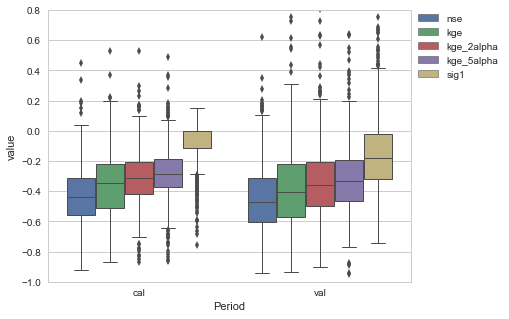

In [7]:
# Construct boxplots for metrics group-by periods
df_pbiasQpeak_cal = pd.DataFrame(pbiasQpeak_cal_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQpeak_val = pd.DataFrame(pbiasQpeak_val_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQpeak_cal['Period'] = ['cal' for _ in df_hcdn['id']]
df_pbiasQpeak_val['Period'] = ['val' for _ in df_hcdn['id']]
df_pbiasQpeak = pd.concat([df_pbiasQpeak_cal, df_pbiasQpeak_val], axis=0)

dd_pbiasQpeak=pd.melt(df_pbiasQpeak, id_vars=['Period'], value_vars=main_obj_fun, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax = sns.boxplot(x='Period', y='value', data=dd_pbiasQpeak, hue='OF', linewidth=1.0)
handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.set_ylim([-1.0,0.8])
plt.savefig('../../Paper5_ffa/supple_figure/pbiasQpeak.boxplot.pdf',
            format='pdf', 
            dpi=300,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

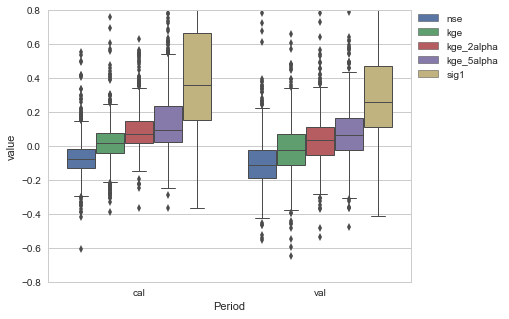

In [8]:
# Construct boxplots for metrics group-by periods
df_pbiasFHV_cal = pd.DataFrame(pbiasFHV_cal_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasFHV_val = pd.DataFrame(pbiasFHV_val_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasFHV_cal['Period'] = ['cal' for _ in df_hcdn['id']]
df_pbiasFHV_val['Period'] = ['val' for _ in df_hcdn['id']]
df_pbiasFHV = pd.concat([df_pbiasFHV_cal, df_pbiasFHV_val], axis=0)

dd=pd.melt(df_pbiasFHV, id_vars=['Period'], value_vars=main_obj_fun, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax2 = sns.boxplot(x='Period', y='value', data=dd, hue='OF', linewidth=1.0)
handles, labels = ax2.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax2.set_ylim([-0.8,0.8])
plt.savefig('../../Paper5_ffa/supple_figure/pbiasFHV.boxplot.pdf',format='pdf', 
            dpi=300, 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

In [9]:
# Annual flood Frequency analysis based on the entire time serise
pbiasQ20_array = np.zeros((nbasin,ndata))
pbiasQ10_array = np.zeros((nbasin,ndata))
pbiasQ5_array = np.zeros((nbasin,ndata))

yrs = pd.date_range('1989-10-01', '2008-09-30', freq='A-SEP')
prob_ann = np.arange(1,float(len(yrs)+1))/(1+float(len(yrs))) #probability
for d in range(len(prob_ann)):
    idx20=d
    if prob_ann[d] > 0.95: break
for d in range(len(prob_ann)):
    idx10=d
    if prob_ann[d] > 0.90: break
for d in range(len(prob_ann)):
    idx5=d
    if prob_ann[d] > 0.80: break

r=0
for hid in df_hcdn['id']:
    for c, obj in enumerate(main_obj_fun): 
        sr_sim = ds_flow_all[obj].sel(hcdn=hid).to_pandas()        
        sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
        sr_sim_ann = sr_sim.resample('A-SEP').max()
        sr_sim_ann_sort = sr_sim_ann.sort_values()
        if c == 0:
            sr_obs = ds_flow_all['obs'].sel(hcdn=hid).to_pandas()
            sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
            sr_obs_ann=sr_obs.resample('A-SEP').max()
            sr_obs_ann_sort = sr_obs_ann.sort_values()
            
            
        pbiasQ20_array[r,c] = pbias(sr_sim_ann_sort[idx20], sr_obs_ann_sort[idx20])
        pbiasQ10_array[r,c] = pbias(sr_sim_ann_sort[idx10], sr_obs_ann_sort[idx10])
        pbiasQ5_array[r,c] = pbias(sr_sim_ann_sort[idx5], sr_obs_ann_sort[idx5])
    r += 1

1. Plot
2. Explore relationship between Calibrated VIC parameter and Attributes

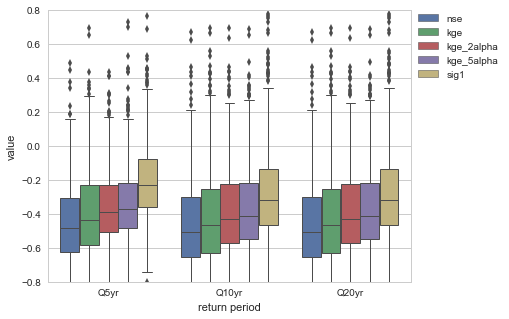

In [10]:
# Construct boxplots for metrics group-by periods
df_pbiasQ20 = pd.DataFrame(pbiasQ20_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQ10 = pd.DataFrame(pbiasQ10_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQ5 = pd.DataFrame(pbiasQ5_array, index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQ20['return period'] = ['Q20yr' for _ in df_hcdn['id']]
df_pbiasQ10['return period'] = ['Q10yr' for _ in df_hcdn['id']]
df_pbiasQ5['return period'] = ['Q5yr' for _ in df_hcdn['id']]

df_pbiasQ = pd.concat([df_pbiasQ5, df_pbiasQ10, df_pbiasQ20], axis=0)

dd_Q = pd.melt(df_pbiasQ, id_vars=['return period'], value_vars=main_obj_fun, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax3 = sns.boxplot(x='return period', y='value', data=dd_Q, hue='OF', linewidth=1.0)
handles, labels = ax3.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax3.set_ylim([-0.8,0.8])
plt.savefig('../../Paper5_ffa/supple_figure/pbiasQ.boxplot.pdf',format='pdf', 
            dpi=300, 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

# Suppelmental objective function

In [11]:
#calibration period
#Initialize arrays
sup_nse_cal_array = np.zeros((nbasin, sup_ndata))
sup_alpha_cal_array = np.zeros((nbasin, sup_ndata))
sup_beta_cal_array = np.zeros((nbasin, sup_ndata))
sup_corr_cal_array = np.zeros((nbasin, sup_ndata))
sup_kge_cal_array = np.zeros((nbasin, sup_ndata))
sup_pbiasFHV_cal_array = np.zeros((nbasin, sup_ndata))
sup_pbiasQpeak_cal_array = np.zeros((nbasin, sup_ndata))
    
r=0
for hid in df_hcdn['id']:
    for c, obj in enumerate(sup_obj_fun): 
        sr_sim = ds_flow_cal[obj].sel(hcdn=hid).to_pandas()        
        sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
        sr_sim_sort = sr_sim.sort_values()
        sr_sim_ann=sr_sim.resample('A-SEP').max()
        if c == 0:
            sr_obs = ds_flow_cal['obs'].sel(hcdn=hid).to_pandas()
            sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
            sr_obs_sort = sr_obs.sort_values()
            sr_obs_ann=sr_obs.resample('A-SEP').max()
            
        sup_nse_cal_array[r,c] = nse(sr_sim, sr_obs)
        sup_alpha_cal_array[r,c] = alpha(sr_sim, sr_obs)
        sup_beta_cal_array[r,c] = beta(sr_sim, sr_obs)
        sup_corr_cal_array[r,c] = corr(sr_sim, sr_obs)
        sup_kge_cal_array[r,c] = kge(sr_sim, sr_obs)
        sup_pbiasQpeak_cal_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
        sup_pbiasFHV_cal_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
    r += 1

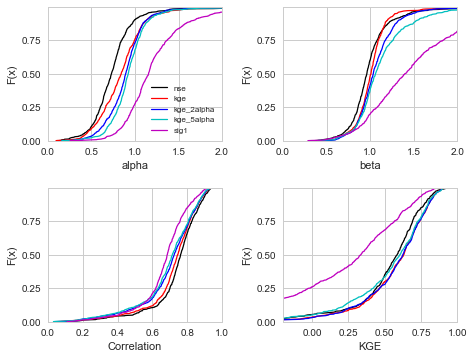

In [30]:
# 4 panel CDFs (alpha, beta, correlation and KGE)

fig = plt.figure(figsize=(6.5, 5.0))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.075,top=0.950,wspace=0.35,hspace=0.35)
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

clr=['k','r','b','c','m','g']
lstyle=['-','-','-','-','-','-','-']

#panel a) alpha
for c in range(ndata):
    xdata = alpha_val_array[:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax1.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax1.legend(loc="lower right",handlelength=2, prop={'size':8})
ax1.set_xlim(0.0, 2.0) #ratio
ax1.set_ylim(0, 1)
ax1.set_yticks(np.arange(0, 1, 0.25))
ax1.set_xlabel('alpha')
ax1.set_ylabel('F(x)')

#panel b) beta
for c in range(ndata):
    xdata = beta_val_array[:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax2.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax2.set_xlim(0.0, 2.0) #ratio
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1, 0.25))
ax2.set_xlabel('beta')
ax2.set_ylabel('F(x)')

#panel c) correlation
for c in range(ndata):
    xdata = corr_val_array[:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax3.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax3.set_xlim(0.0, 1.0) # corr
ax3.set_ylim(0, 1)
ax3.set_yticks(np.arange(0, 1, 0.25))
ax3.set_xlabel('Correlation')
ax3.set_ylabel('F(x)')

#panel d) KGE
for c in range(ndata):
    xdata = kge_val_array[:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax4.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax4.set_xlim(-0.2, 1.0)
ax4.set_ylim(0, 1)
ax4.set_yticks(np.arange(0, 1, 0.25))
ax4.set_xlabel('KGE')
ax4.set_ylabel('F(x)')